# Paper Images

In [976]:
import os
import re
import csv
import sys
import json
import copy
import string
import xml.etree.ElementTree as ET
import nltk
nltk.download('words')
from nltk import sent_tokenize
from nltk.corpus import words
from IPython.display import Image
import random
import numpy as np
from termcolor import colored

from IPython.display import HTML as html_print
from IPython.display import Markdown

import cv2
import pandas as pd

import nltk
from nltk import agreement
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from collections import Counter
from scipy.stats import pearsonr
from sklearn.metrics import cohen_kappa_score

from utils import label_samples

from matplotlib import pyplot as plt
%pylab inline
import seaborn as sns
sns.set(color_codes=True)
sns.set_style("ticks")

SPELLCHECKER_WORDS = set(words.words())
DEBUG = False

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package words to
[nltk_data]     /nas/home/telinwu/nltk_data...
[nltk_data]   Package words is already up-to-date!
/nas/home/telinwu/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generals

In [779]:
# qualtric ids
def get_qualt_ids(start_block=1, end_block=24):
    print ('-'*50)
    start_block += 1
    end_block += 2
    start_block = max(2, start_block)
    end_block = min(26, end_block)
    print ("Version: {} instances".format((end_block-start_block)*30))
    qualt_ids = []
    for block in range(start_block, end_block):
        for ques_idx in range(1, 31):
            qualt_id = "{}_Q{}".format(ques_idx, block)
            qualt_ids.append(qualt_id)
    return qualt_ids

In [967]:
from macros import *

DICT_STRS = {
    "overall": "1. choice",
    "conf": "2. confidence",
    "others": "3. others agreement",
    "com": "4. if common sense",
    "mcq_com": "4. if common sense",
    "bin_com": "4. if common sense",
    "edu": "5. education level",
    "clearness": "6. clearness",
    "cat": "7. category",
}

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Processed Dicts (JSON)

In [15]:
mcq_dict_f = "../outputs/piqa_qualt_sorted_dict.json"
bin_dict_f = "../outputs/binpiqa_qualt_sorted_dict.json"
mcq_qualt_dict = json.load(open(mcq_dict_f, "r"))
bin_qualt_dict = json.load(open(bin_dict_f, "r"))
qualt_dicts = (mcq_qualt_dict, bin_qualt_dict)

### Adding BIN-COMPL

In [747]:
bin_compl_f = "../outputs/binpiqa_compl_qualt_sorted_dict.json"
bin_compl_qualt_dict = json.load(open(bin_compl_f, "r"))
compl_samples_csv = open("../files/binpiqa_survey_sampels_complementary.csv", "r")
compl_csvr = csv.DictReader(compl_samples_csv)
compl_qualt_ids_mappings = {}

for row in compl_csvr:
    if len(row["goal"]) == 0:
        continue
    org_id = row["qualtid_org"]
    new_id = row["qualtid_new"]
    compl_qualt_ids_mappings[new_id] = org_id

for quald_id in compl_qualt_ids_mappings:
    if 'annotations' not in bin_compl_qualt_dict[quald_id]:
        continue
    if len(bin_compl_qualt_dict[quald_id]['annotations']) == 0:
        continue
    compl_choices = bin_compl_qualt_dict[quald_id]['annotations']['1. choice']
    org_id = compl_qualt_ids_mappings[quald_id]
    bin_qualt_dict[org_id]['annotations']['1. choice compl'] = compl_choices
    bin_qualt_dict[org_id]['gt_label_compl'] = bin_compl_qualt_dict[quald_id]['gt_label']
    
    org_choices = bin_qualt_dict[org_id]['annotations']['1. choice']
    org_choices_counter = Counter(org_choices)
    org_choice, org_choice_cnt = org_choices_counter.most_common(1)[0]
    assert org_choice_cnt >= len(org_choices) // 2
    
    org_correct = org_choice == bin_qualt_dict[org_id]['gt_label']
    if not org_correct:
        print (bin_qualt_dict[org_id])
        raise

qualt_dicts = (mcq_qualt_dict, bin_qualt_dict)

## Pie Charts

In [702]:
# functions
def draw_pie_charts_for_cat_data(qualt_dicts, mode="edu", start_block=1, end_block=24, figsize=(8,8), save_str=None):
    assert mode in ["edu", "cat", "clearness"]
    mcq_qualt_dict, bin_qualt_dict = qualt_dicts
    qualt_ids = get_qualt_ids(start_block=start_block, end_block=end_block)
    
    curr_cat_name = CAT_NAMES[mode]
    qualt_type = DICT_STRS[mode]
    curr_id_dict = CAT_ID_DICTS[mode]
    curr_dict = CAT_DICTS[mode]
    print ("{}: {}".format(curr_cat_name, qualt_type))
    
    res = []
    
    for qualt_id in qualt_ids:
        mcq_annots = mcq_qualt_dict[qualt_id]["annotations"]
        bin_annots = bin_qualt_dict[qualt_id]["annotations"]
        mcq_cat = mcq_annots[qualt_type]
        bin_cat = bin_annots[qualt_type]
        
        # current logic, have it as long as >= 2 agreed
        if mode in ["edu", "clearness"]:
            joint_cat = mcq_cat + bin_cat
        elif mode in ["cat"]:
            joint_cat = []
            for each in mcq_cat:
                joint_cat += each
            for each in bin_cat:
                joint_cat += each            
        else:
            raise ValueError("No such categorical data: {}".format(mode))
        joint_counter = Counter(joint_cat)
        no_geq_2 = True
        for ele, cnt in joint_counter.items():
            if cnt > 2:
                res.append(ele)
                no_geq_2 = False
        if no_geq_2:
            res.append(curr_dict["Not sure"])
                
    res_counter = Counter(res)
    labels = []
    sizes = []
    for id_ in sorted(curr_id_dict):
        id_str = curr_id_dict[id_]
        if id_ in res_counter:
            id_cnt = res_counter[id_]
            labels.append(id_str)
            sizes.append(id_cnt)
        else:
            id_cnt = 0
        print ("{}: {}".format(id_str, id_cnt))

        
    # Pie chart
    #colors
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', 'violet', 'lightgray']
    
    #explsion
    explode = [0.02] * len(labels)
    
    fig1, ax1 = plt.subplots(figsize=figsize)
    wedges, texts, autotexts = ax1.pie(sizes, colors = colors,
                                       # labels=labels,
                                       autopct='%1.1f%%',
                                       startangle=90, pctdistance=0.75,
                                       wedgeprops=dict(width=0.5),
                                       shadow=False,
                                       explode=explode)
    
    
    """
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax1.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)
    """
    
    legend = ax1.legend(wedges, labels,
                        title=curr_cat_name,
                        loc="lower center",
                        fontsize=14,
                        bbox_to_anchor=(0.33, -0.24, 0.3, 0.5))
        
    plt.setp(autotexts, **{'weight':'bold', 'fontsize':16})
    plt.setp(legend.get_title(), fontsize=16)
    
    #draw circle
    centre_circle = plt.Circle((0,0), 0.50, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')
    # ax1.set_title(curr_cat_name, fontsize=18)
    plt.tight_layout()
    plt.show()
    
    if save_str is not None:
        fig1.savefig(save_str, bbox_inches='tight')
            
    return None

### Educational Levels

Version: 720 instances
--------------------------------------------------
Demographics: 5. education level
Most 10 year olds: 225
Not most 10 year olds: 329
Only domain experts: 112
Not sure: 100


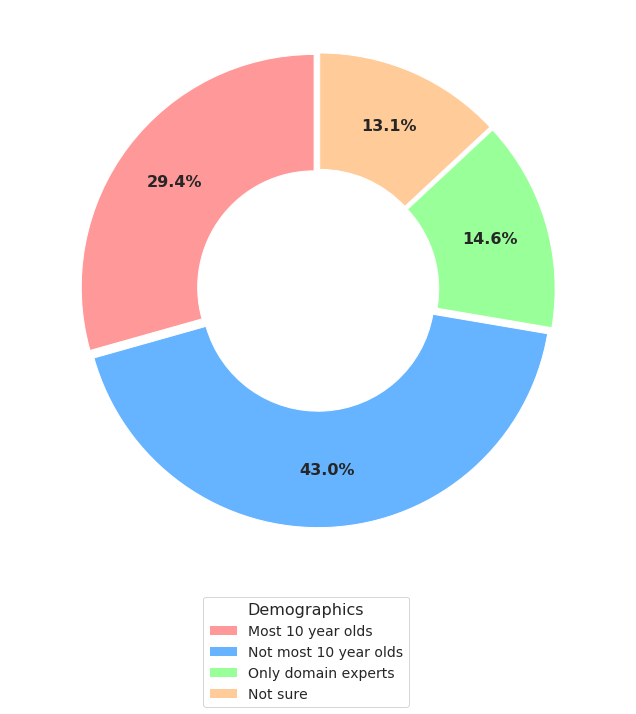

In [703]:
save_str = "imgs/edu_pie_charts.pdf"
draw_pie_charts_for_cat_data(qualt_dicts, mode="edu", end_block=24, figsize=(9,10), save_str=save_str)

### Categories

Version: 720 instances
--------------------------------------------------
Physical Common Sense Categories: 7. category
Typical Functions: 256
Affordances: 175
Spatial Relationships: 45
Definitional Attributes: 161
Everyday Knowledge: 270
Not sure: 221


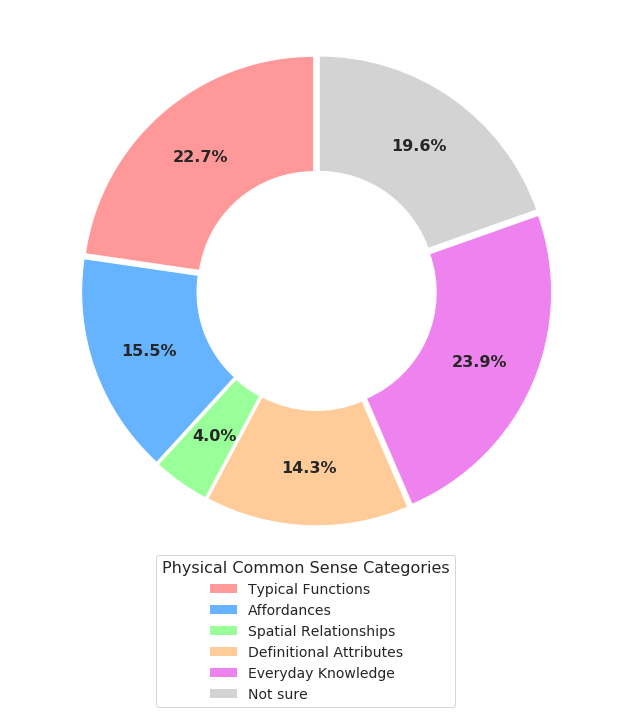

In [704]:
save_str = "imgs/cat_pie_charts.pdf"
draw_pie_charts_for_cat_data(qualt_dicts, mode="cat", end_block=24, figsize=(9,10), save_str=save_str)

## Column Charts

In [1010]:
# functions
def draw_column_charts_for_cond_perfs(qualt_dicts, mode="com", start_block=1, end_block=24,
                                      models_to_plot_and_str_mappings=None, bin_compl=False,
                                      bar_width=0.25, figsize=(8,8), plotting_axis_swap=False,
                                      add_overall=False, ylim=110, with_hard=False, save_str=None):

    assert mode in ["edu", "cat", "com", "clearness", "overall",
                    "mcq_com", "mcq_cat", "bin_com", "bin_cat"]
    mcq_qualt_dict, bin_qualt_dict = qualt_dicts
    qualt_ids = get_qualt_ids(start_block=start_block, end_block=end_block)
    
    # get number of annotators
    mcq_models = []
    bin_models = []
    num_annotators_per_question = 0

    annots = mcq_qualt_dict[qualt_ids[0]]["annotations"]["1. choice"]
    num_annots = len(annots)
    num_annotators_per_question = max(num_annotators_per_question, num_annots)
    num_iaas = num_annotators_per_question * 2
    
    mcq_models += list(mcq_qualt_dict[qualt_ids[0]]["model_preds"].keys())
    bin_models += list(bin_qualt_dict[qualt_ids[0]]["model_preds"].keys())
    
    curr_cat_name = CAT_NAMES[mode]
    qualt_type = DICT_STRS[mode]
    curr_id_dict = CAT_ID_DICTS[mode]
    if add_overall:
        curr_id_dict[-100] = "Overall"
    print ("{}: {}".format(curr_cat_name, qualt_type))
    
    all_models = mcq_models + bin_models + ["MCQ-Humans", "BIN-Humans"]
    
    if with_hard:
        assert start_block == 1 and end_block == 20
        qualt_ids_hard = get_qualt_ids(start_block=21, end_block=24)
        res_rand = {k: {m: [] for m in all_models} for k in curr_id_dict}
        res_hard = {k: {m: [] for m in all_models} for k in curr_id_dict}
        qualt_ids += qualt_ids_hard
    else:
        res = {k: {m: [] for m in all_models} for k in curr_id_dict}
    
    for qualt_id in qualt_ids:
        mcq_annots = mcq_qualt_dict[qualt_id]["annotations"]
        bin_annots = bin_qualt_dict[qualt_id]["annotations"]
        mcq_gt = mcq_qualt_dict[qualt_id]["gt_label"]
        bin_gt = bin_qualt_dict[qualt_id]["gt_label"]
        mcq_cat = mcq_annots[qualt_type]
        bin_cat = bin_annots[qualt_type]
        
        if bin_compl:
            if 'gt_label_compl' in bin_qualt_dict[qualt_id]:
                bin_gt_compl = bin_qualt_dict[qualt_id]["gt_label_compl"]
                assert bin_gt_compl == 1 - bin_gt
        
        mcq_human_choices = mcq_annots["1. choice"]
        bin_human_choices = bin_annots["1. choice"]
        mcq_human_choices_counter = Counter(mcq_human_choices)
        bin_human_choices_counter = Counter(bin_human_choices)
        mcq_human_choice, mcq_human_choice_cnt = mcq_human_choices_counter.most_common(1)[0]
        bin_human_choice, bin_human_choice_cnt = bin_human_choices_counter.most_common(1)[0]

        if bin_compl:
            if "1. choice compl" in bin_annots:
                bin_human_choices_compl = bin_annots["1. choice compl"]
                bin_human_choices_compl_counter = Counter(bin_human_choices_compl)
                bin_human_choice_compl, bin_human_choice_compl_cnt = bin_human_choices_compl_counter.most_common(1)[0]
        
        assert mcq_human_choice_cnt > num_annotators_per_question // 2 and \
            bin_human_choice_cnt > num_annotators_per_question // 2
        
        # overall performances
        if mode == "overall":
            curr_res_keys = [0]
            
        # current logic, have it as long as >= 2 agreed
        elif mode in ["edu", "clearness", "cat"]:
            if mode in ["edu", "clearness"]:
                joint_cat = mcq_cat + bin_cat
            elif mode in ["cat"]:
                joint_cat = []
                for each in mcq_cat:
                    joint_cat += each
                for each in bin_cat:
                    joint_cat += each            
            else:
                raise ValueError("No such categorical data: {}".format(mode))
            
            joint_counter = Counter(joint_cat)
            curr_res_keys = []
            for ele, cnt in joint_counter.items():
                if cnt > 2:
                    if mode == "cat" and ele >= 5:
                        continue
                    curr_res_keys.append(ele)
                    
        # common sense
        elif "com" in mode:
            if mode == "mcq_com":
                joint_cat = mcq_cat
            elif mode == "bin_com":
                joint_cat = bin_cat
            else:
                joint_cat = mcq_cat + bin_cat
            joint_counter = Counter(joint_cat)
            joint_if_cs, joint_if_cs_cnt = joint_counter.most_common(1)[0]
            curr_if_cs = None
            if joint_if_cs_cnt > len(joint_cat) // 2:
                if joint_if_cs == 1:
                    curr_if_cs = 1
                else:
                    curr_if_cs = -1
            elif joint_if_cs_cnt == len(joint_cat) // 2:
                curr_if_cs = 0
            else:
                raise
            curr_res_keys = [curr_if_cs]
            
        if add_overall:
            curr_res_keys.append(-100)
            
        if with_hard:
            if qualt_id in qualt_ids_hard:
                res = res_hard
            else:
                res = res_rand

        # record model performances
        for curr_res_key in curr_res_keys:
            for model in mcq_models:
                if mcq_qualt_dict[qualt_id]["model_preds"][model] == mcq_gt:
                    res[curr_res_key][model].append(1)
                else:
                    res[curr_res_key][model].append(0)
            if bin_compl:
                for model in bin_models:
                    if bin_qualt_dict[qualt_id]["model_preds"][model] == bin_gt \
                      and bin_qualt_dict[qualt_id]["model_preds_compl"][model] == 1-bin_gt:
                        res[curr_res_key][model].append(1)
                    else:
                        res[curr_res_key][model].append(0)
            else:
                for model in bin_models:
                    if bin_qualt_dict[qualt_id]["model_preds"][model] == bin_gt:
                        res[curr_res_key][model].append(1)
                    else:
                        res[curr_res_key][model].append(0)
            if mcq_human_choice == mcq_gt:
                res[curr_res_key]["MCQ-Humans"].append(1)
            else:
                res[curr_res_key]["MCQ-Humans"].append(0)
            if bin_compl:
                if "1. choice compl" in bin_annots:
                    if bin_human_choice == bin_gt and bin_human_choice_compl == bin_gt_compl:
                        res[curr_res_key]["BIN-Humans"].append(1)
                    else:
                        res[curr_res_key]["BIN-Humans"].append(0)
            else:
                if bin_human_choice == bin_gt:
                    res[curr_res_key]["BIN-Humans"].append(1)
                else:
                    res[curr_res_key]["BIN-Humans"].append(0)
    
    print ('-'*50)
    groups = []
    bars = []
    labels = []
    res_keys = list(res.keys())
    
    if models_to_plot_and_str_mappings is None:
        plot_models = all_models
    else:
        plot_models = list(models_to_plot_and_str_mappings.keys())
        
    if with_hard:
        res = res_rand
    
    for key in res_keys:
        cat_str = curr_id_dict[key]
        print (cat_str)
        groups.append(cat_str)
        bars_tmp = []
        for model in plot_models:
            res_l = np.asarray(res[key][model])
            res_l_acc = np.mean(res_l) * 100.0
            print ("{}: {:.4f}%".format(model, res_l_acc))
            bars_tmp.append(round(res_l_acc, 2))
            if model not in labels:
                if models_to_plot_and_str_mappings is None:
                    labels.append(model)
                else:
                    if models_to_plot_and_str_mappings[model] not in labels:
                        labels.append(models_to_plot_and_str_mappings[model])
        bars.append(bars_tmp)
        print ('-'*50)
        
    colors = ["lightgreen", "lightcoral", "lightblue", "lightyellow", "lightgrey"]
    
    if plotting_axis_swap:
        groups_tmp = groups
        labels_tmp = labels
        groups = labels_tmp
        labels = groups_tmp
        bars = np.asarray(bars)
        bars = np.transpose(bars)
    
    fig = plot_grouped_bars(bars, labels, groups, colors, title_str=curr_cat_name, 
                            fig_size=figsize, bar_width=bar_width, ylim=ylim)
    
    if with_hard:
        groups = []
        bars = []
        labels = []
        res = res_hard
        for key in res_keys:
            cat_str = curr_id_dict[key]
            print (cat_str)
            groups.append(cat_str)
            bars_tmp = []
            for model in plot_models:
                res_l = np.asarray(res[key][model])
                res_l_acc = np.mean(res_l) * 100.0
                print ("{}: {:.4f}%".format(model, res_l_acc))
                bars_tmp.append(round(res_l_acc, 2))
                if model not in labels:
                    if models_to_plot_and_str_mappings is None:
                        labels.append(model)
                    else:
                        if models_to_plot_and_str_mappings[model] not in labels:
                            labels.append(models_to_plot_and_str_mappings[model])
            bars.append(bars_tmp)
            print ('-'*50)

        colors = ["limegreen", "indianred", "skyblue", "yellow", "grey"]

        if plotting_axis_swap:
            groups_tmp = groups
            labels_tmp = labels
            groups = labels_tmp
            labels = groups_tmp
            bars = np.asarray(bars)
            bars = np.transpose(bars)

        plot_grouped_bars(bars, labels, groups, colors, title_str=curr_cat_name, 
                          fig_size=figsize, bar_width=bar_width,
                          ylim=ylim, with_hard=with_hard)
    
    if save_str is not None:
        fig.savefig(save_str, bbox_inches='tight')
    
    return fig


def plot_grouped_bars(bars, labels, groups, colors, title_str, save_imgs_dir=None, 
                      fig_size=10, bar_width=0.25, ylim=110, with_hard=False):
    # set width of bar
    barWidth = bar_width
    
    # Set position of bar on X axis
    rs = []
    rs.append(np.arange(len(bars[0])))
    for i in range(1, len(groups)):
        rs.append([x + barWidth for x in rs[-1]])

    if not with_hard:
        if type(fig_size) == int:
            fig = plt.figure(figsize=(fig_size, fig_size))
        else:
            fig = plt.figure(figsize=fig_size)
     
    # Make the plot
    print (groups)
    for i in range(len(groups)):
        rects = plt.bar(rs[i], bars[i], color=colors[i], width=barWidth, edgecolor='black', 
                        linewidth=2, label=groups[i])
        for rect in rects:
            height = rect.get_height()
            plt.annotate('{}'.format(height),
                         xy=(rect.get_x() + rect.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         fontsize=32,
                         ha='center', va='bottom')
     
    # Add xticks on the middle of the group bars
    # plt.set_yscale('log') (len(groups)-1)/
    plt.xticks([r + barWidth*len(groups)/2-bar_width/2 for r in range(len(bars[0]))], labels)
    # plt.title(title_str, fontsize=24)
    plt.xticks(rotation=0, fontsize=32) 
    plt.yticks(fontsize=32)
    plt.ylim(0, ylim)
    
    # Create legend & Show graphic
    if not with_hard:
        plt.legend(fontsize=32, loc='upper center', shadow=True, ncol=len(groups))
    
    if with_hard:
        return None
    
    return fig

In [896]:
# adding model performances
model_perf_root = "../../ai2_light_telin/outputs"

mcq_model_lsts = [
    os.path.join(model_perf_root, "physicaliqa_ablated2/large_roberta_bz4_accu2"),
    os.path.join(model_perf_root, "physicaliqa_ablated2/lm_finetuned_piqa_existed_cn_iter20k_bz3_accu1"),
    os.path.join(model_perf_root, "physicaliqa_ablated2/lm_finetuned_cn100k_iter60k_bz3_accu1"),
    os.path.join(model_perf_root, "physicaliqa_ablated/lm_finetuned_piqa_train_with_gt_iter60k_bz3_accu1"),
    os.path.join(model_perf_root, "physicaliqa/lm_finetuned_entity_based_postag_piqa_train_with_gt_iter60k_bz3_accu1"),
    os.path.join(model_perf_root, "physicaliqa/large_roberta_bz3_accu1_seed2"),
    os.path.join(model_perf_root, "physicaliqa/large_roberta_bz3_accu1_seed3"),
]

bin_model_lsts = [
    os.path.join(model_perf_root, "physicalbinqa/param_sweep_binqa_5050/bz4_accu1_v2_contd"),
    os.path.join(model_perf_root, "physicalbinqa/lm_finetuned_piqa_train_with_gt_iter60k_bz3_accu1"),
    os.path.join(model_perf_root, "physicalbinqa/lm_finetuned_entity_based_postag_piqa_train_with_gt_iter60k_bz3_accu1"),
]

In [897]:
class Args(object):
    def __init__(self):
        self.mcq_model_preds = mcq_model_lsts
        self.bin_model_preds = bin_model_lsts
        self.mcq_samples_csv = "../files/piqa_survey_sampels_all.csv"
        self.bin_samples_csv = "../files/binpiqa_survey_sampels_all.csv"
        self.mcq_data_jsonl = "../files/dev.jsonl"
        self.mcq_data_lst = "../files/dev-labels.lst"
        self.bin_data_jsonl = "../files/bin-dev.jsonl"
        self.bin_data_lst = "../files/bin-dev-labels.lst"
        self.num_total_blocks = 24
        self.num_questions_each = 30
        
args = Args()
args.data_lst = args.mcq_data_lst

args.task = "physicaliqa"
args.data_jsonl = args.mcq_data_jsonl
args.data_lst = args.mcq_data_lst
args.samples_csv = args.mcq_samples_csv
mcq_qualt_sorted_dict, qualt_id_ai2_id_mapping, ai2_id_qualt_id_mapping = label_samples(args)

args.task = "physicalbinqa"
args.data_jsonl = args.bin_data_jsonl
args.data_lst = args.bin_data_lst
args.samples_csv = args.bin_samples_csv
bin_qualt_sorted_dict, _, _ = label_samples(args)

for qualt_id  in mcq_qualt_sorted_dict:
    if qualt_id not in mcq_qualt_dict:
        continue
    if qualt_id not in bin_qualt_dict:
        continue
    mcq_qualt_dict[qualt_id]["model_preds"] = mcq_qualt_sorted_dict[qualt_id]["model_preds"]
    bin_qualt_dict[qualt_id]["model_preds"] = bin_qualt_sorted_dict[qualt_id]["model_preds"]
    bin_qualt_dict[qualt_id]["model_preds_compl"] = bin_qualt_sorted_dict[qualt_id]["model_preds_compl"]
    
qualt_dicts = (mcq_qualt_dict, bin_qualt_dict)

[INFO] Num Each Block:   30
[INFO] Num Total Blocks: 24
[INFO] Num Each Block:   30
[INFO] Num Total Blocks: 24


### Overall

--------------------------------------------------
Version: 600 instances
Overall Performances: 1. choice
--------------------------------------------------
Performance
MCQ-Humans: 95.0000%
mcq_large_roberta_bz4_accu2: 80.3333%
mcq_large_roberta_bz3_accu1_seed2: 80.5000%
mcq_large_roberta_bz3_accu1_seed3: 81.0000%
BIN-Humans: 80.0000%
bin_bz4_accu1_v2_contd: 67.8333%
--------------------------------------------------
['Performance']


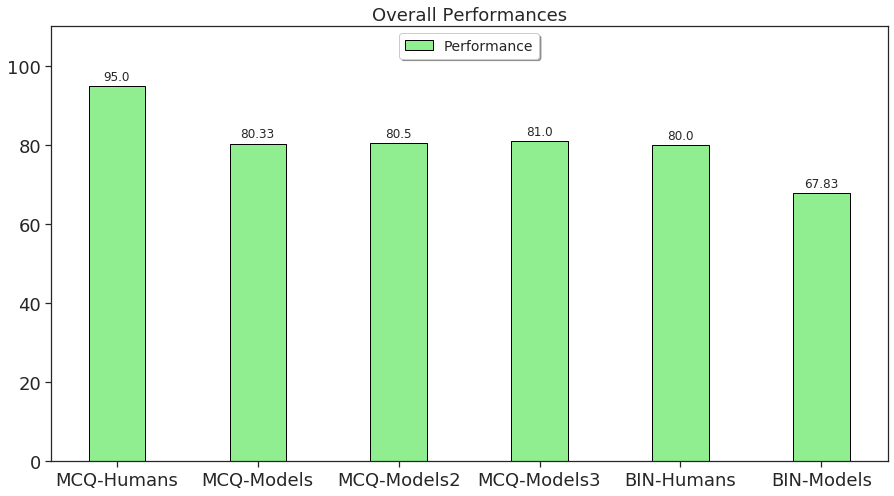

In [898]:
models_to_plot_and_str_mappings = {
    "MCQ-Humans": "MCQ-Humans",
    "mcq_large_roberta_bz4_accu2": "MCQ-Models",
    "mcq_large_roberta_bz3_accu1_seed2": "MCQ-Models2",
    "mcq_large_roberta_bz3_accu1_seed3": "MCQ-Models3",
    "BIN-Humans": "BIN-Humans",
    "bin_bz4_accu1_v2_contd": "BIN-Models",
}
save_str = "imgs/overall_bars_humans_models.pdf"
fig = draw_column_charts_for_cond_perfs(qualt_dicts, mode="overall", start_block=1, end_block=20, 
                                        models_to_plot_and_str_mappings=models_to_plot_and_str_mappings, 
                                        bin_compl=False,
                                        bar_width=0.4, figsize=(15,8), save_str=save_str)

### If Common Sense

--------------------------------------------------
Version: 600 instances
Is Common Sense: 4. if common sense
--------------------------------------------------
Common Sense
MCQ-Humans: 97.5000%
mcq_large_roberta_bz4_accu2: 83.0000%
mcq_large_roberta_bz3_accu1_seed2: 81.0000%
mcq_large_roberta_bz3_accu1_seed3: 81.2500%
BIN-Humans: 84.7500%
bin_bz4_accu1_v2_contd: 68.2500%
--------------------------------------------------
Not Common Sense
MCQ-Humans: 88.2812%
mcq_large_roberta_bz4_accu2: 77.3438%
mcq_large_roberta_bz3_accu1_seed2: 80.4688%
mcq_large_roberta_bz3_accu1_seed3: 82.8125%
BIN-Humans: 70.3125%
bin_bz4_accu1_v2_contd: 65.6250%
--------------------------------------------------
Neutral
MCQ-Humans: 93.0556%
mcq_large_roberta_bz4_accu2: 70.8333%
mcq_large_roberta_bz3_accu1_seed2: 77.7778%
mcq_large_roberta_bz3_accu1_seed3: 76.3889%
BIN-Humans: 70.8333%
bin_bz4_accu1_v2_contd: 69.4444%
--------------------------------------------------
Overall
MCQ-Humans: nan%
mcq_large_roberta_bz

/nas/home/telinwu/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nas/home/telinwu/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


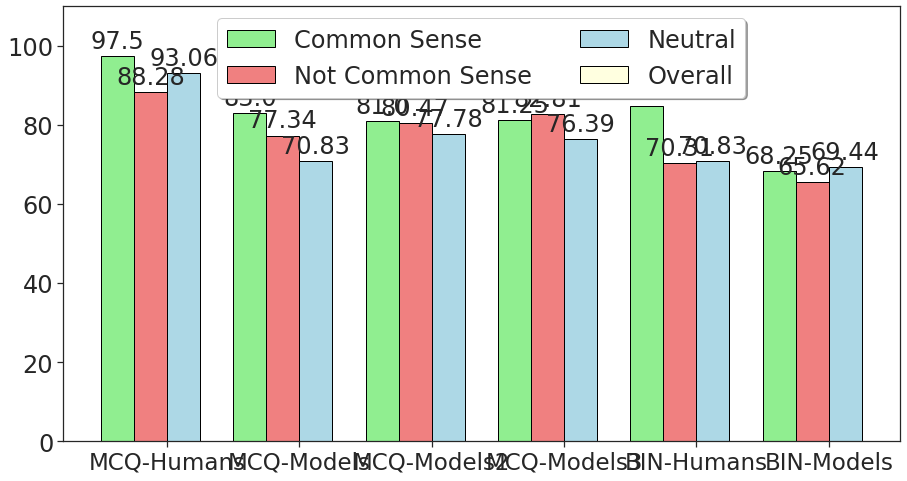

In [942]:
models_to_plot_and_str_mappings = {
    "MCQ-Humans": "MCQ-Humans",
    "mcq_large_roberta_bz4_accu2": "MCQ-Models",
    "mcq_large_roberta_bz3_accu1_seed2": "MCQ-Models2",
    "mcq_large_roberta_bz3_accu1_seed3": "MCQ-Models3",
    "BIN-Humans": "BIN-Humans",
    "bin_bz4_accu1_v2_contd": "BIN-Models",
}
save_str = "imgs/grouped_bars_humans_models_if_cs.pdf"
fig = draw_column_charts_for_cond_perfs(qualt_dicts, mode="com", start_block=1, end_block=20, 
                                        models_to_plot_and_str_mappings=models_to_plot_and_str_mappings,
                                        bin_compl=False,
                                        bar_width=0.25, figsize=(15,8), save_str=save_str)

--------------------------------------------------
Version: 600 instances
Is Common Sense: 4. if common sense
--------------------------------------------------
Version: 120 instances
--------------------------------------------------
Common Sense
mcq_large_roberta_bz3_accu1_seed2: 81.0000%
mcq_lm_finetuned_piqa_train_with_gt_iter60k_bz3_accu1: 81.0000%
mcq_lm_finetuned_entity_based_postag_piqa_train_with_gt_iter60k_bz3_accu1: 78.2500%
--------------------------------------------------
Not Common Sense
mcq_large_roberta_bz3_accu1_seed2: 80.4688%
mcq_lm_finetuned_piqa_train_with_gt_iter60k_bz3_accu1: 83.5938%
mcq_lm_finetuned_entity_based_postag_piqa_train_with_gt_iter60k_bz3_accu1: 74.2188%
--------------------------------------------------
Neutral
mcq_large_roberta_bz3_accu1_seed2: 77.7778%
mcq_lm_finetuned_piqa_train_with_gt_iter60k_bz3_accu1: 73.6111%
mcq_lm_finetuned_entity_based_postag_piqa_train_with_gt_iter60k_bz3_accu1: 81.9444%
-------------------------------------------------

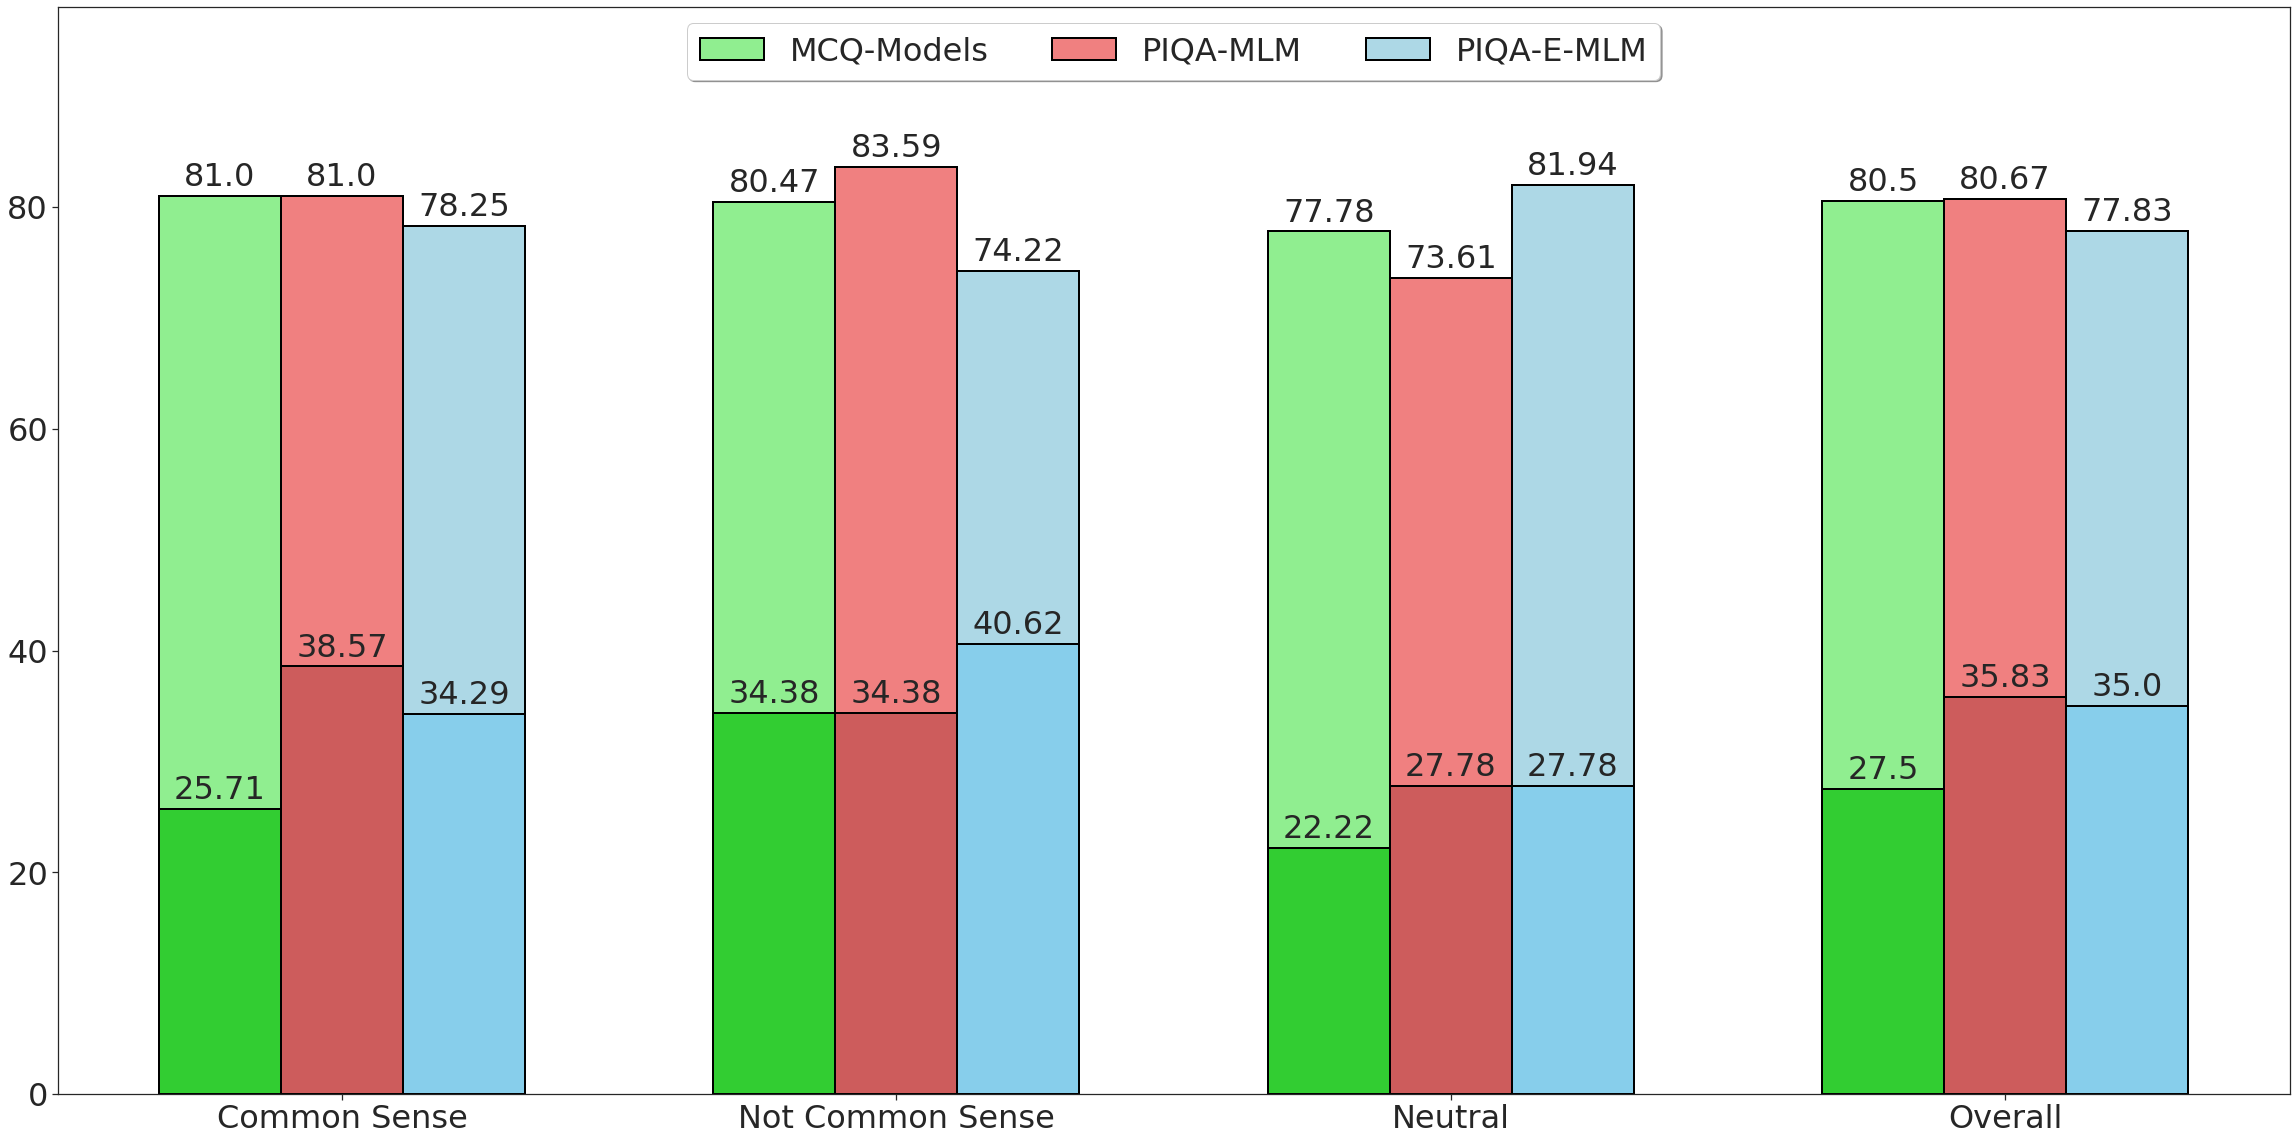

In [1011]:
models_to_plot_and_str_mappings = {
    # "mcq_large_roberta_bz4_accu2": "MCQ-Models",
    "mcq_large_roberta_bz3_accu1_seed2": "MCQ-Models",
    # "lm_finetuned_cn100k_iter60k_bz3_accu1": "CN100k w. MLM",
    "mcq_lm_finetuned_piqa_train_with_gt_iter60k_bz3_accu1": "PIQA-MLM",
    "mcq_lm_finetuned_entity_based_postag_piqa_train_with_gt_iter60k_bz3_accu1": "PIQA-E-MLM",
    # "lm_finetuned_piqa_existed_cn_iter20k_bz3_accu1": "PIQA-Train-GT w. C-MLM",
}
save_str = "imgs/grouped_bars_more_models_if_cs.pdf"
fig = draw_column_charts_for_cond_perfs(qualt_dicts, mode="com", start_block=1, end_block=20, 
                                        models_to_plot_and_str_mappings=models_to_plot_and_str_mappings, 
                                        plotting_axis_swap=True, add_overall=True, ylim=98,
                                        with_hard=True, bar_width=0.22, figsize=(40,20),
                                        save_str=save_str)

--------------------------------------------------
Version: 600 instances
Is Common Sense: 4. if common sense
--------------------------------------------------
Version: 120 instances
--------------------------------------------------
Common Sense
bin_bz4_accu1_v2_contd: 68.2500%
bin_lm_finetuned_piqa_train_with_gt_iter60k_bz3_accu1: 69.0000%
bin_lm_finetuned_entity_based_postag_piqa_train_with_gt_iter60k_bz3_accu1: 66.7500%
--------------------------------------------------
Not Common Sense
bin_bz4_accu1_v2_contd: 65.6250%
bin_lm_finetuned_piqa_train_with_gt_iter60k_bz3_accu1: 62.5000%
bin_lm_finetuned_entity_based_postag_piqa_train_with_gt_iter60k_bz3_accu1: 60.9375%
--------------------------------------------------
Neutral
bin_bz4_accu1_v2_contd: 69.4444%
bin_lm_finetuned_piqa_train_with_gt_iter60k_bz3_accu1: 65.2778%
bin_lm_finetuned_entity_based_postag_piqa_train_with_gt_iter60k_bz3_accu1: 65.2778%
--------------------------------------------------
Overall
bin_bz4_accu1_v2_contd:

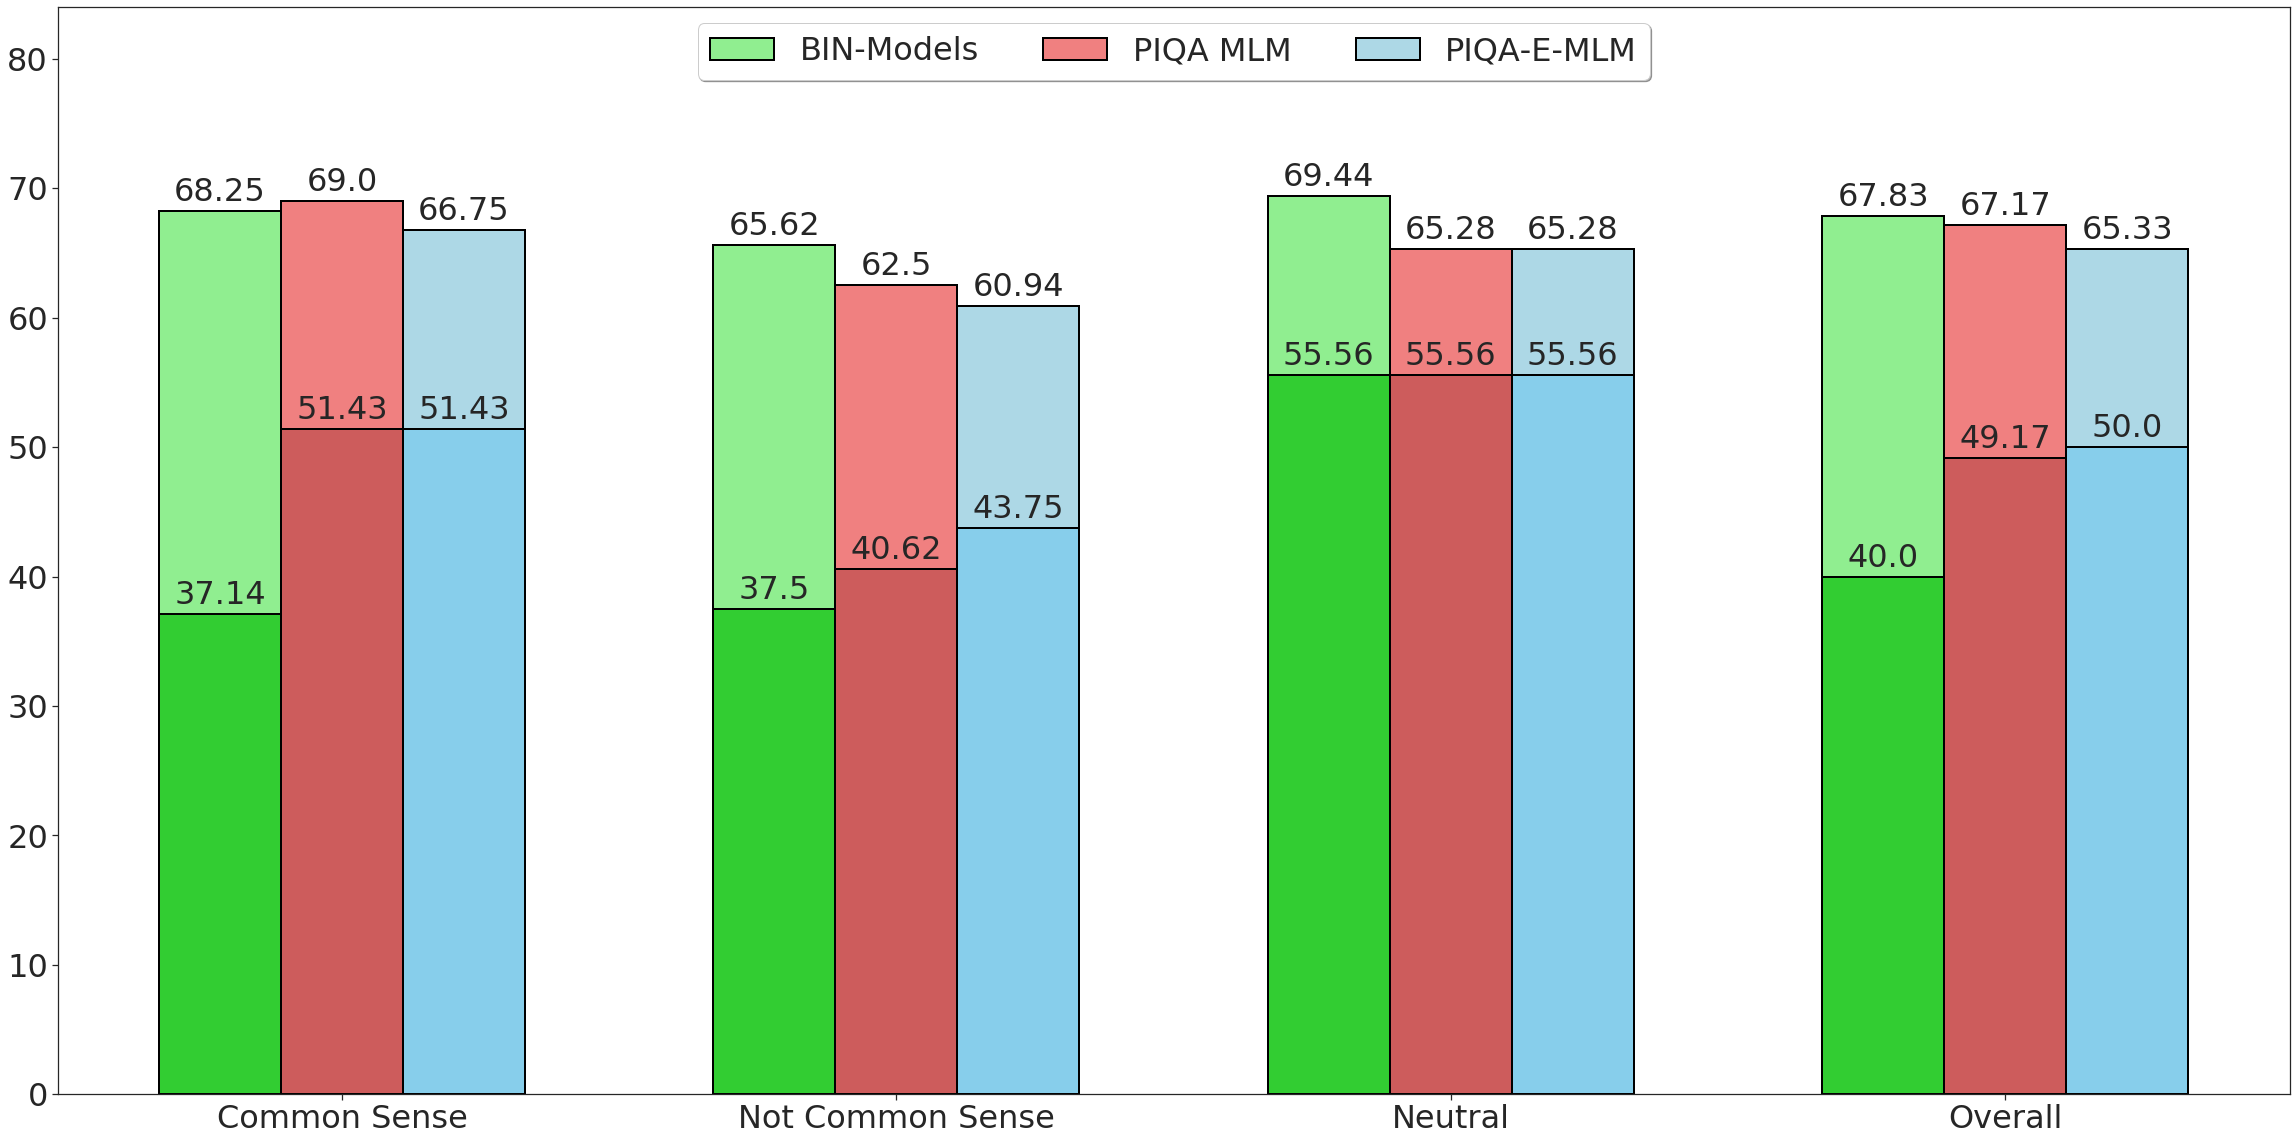

In [1014]:
models_to_plot_and_str_mappings = {
    "bin_bz4_accu1_v2_contd": "BIN-Models",
    "bin_lm_finetuned_piqa_train_with_gt_iter60k_bz3_accu1": "PIQA MLM",
    "bin_lm_finetuned_entity_based_postag_piqa_train_with_gt_iter60k_bz3_accu1": "PIQA-E-MLM",
}
save_str = "imgs/grouped_bars_more_bin_models_if_cs.pdf"
fig = draw_column_charts_for_cond_perfs(qualt_dicts, mode="com", start_block=1, end_block=20, 
                                        models_to_plot_and_str_mappings=models_to_plot_and_str_mappings, 
                                        plotting_axis_swap=True, add_overall=True, ylim=84,
                                        with_hard=True, bar_width=0.22, figsize=(40,20),
                                        save_str=save_str)

### Categories

Version: 600 instances
--------------------------------------------------
Physical Common Sense Categories: 7. category
--------------------------------------------------
Typical Functions
MCQ-Humans: 98.6667%
large_roberta_bz4_accu2: 84.0000%
BIN-Humans: 82.2222%
bz4_accu1_v2_contd: 69.7778%
--------------------------------------------------
Affordances
MCQ-Humans: 92.2535%
large_roberta_bz4_accu2: 75.3521%
BIN-Humans: 72.5352%
bz4_accu1_v2_contd: 64.7887%
--------------------------------------------------
Spatial Relationships
MCQ-Humans: 100.0000%
large_roberta_bz4_accu2: 82.0513%
BIN-Humans: 87.1795%
bz4_accu1_v2_contd: 71.7949%
--------------------------------------------------
Definitional Attributes
MCQ-Humans: 94.8529%
large_roberta_bz4_accu2: 81.6176%
BIN-Humans: 79.4118%
bz4_accu1_v2_contd: 68.3824%
--------------------------------------------------
Everyday Knowledge
MCQ-Humans: 98.3333%
large_roberta_bz4_accu2: 80.4167%
BIN-Humans: 85.4167%
bz4_accu1_v2_contd: 70.0000%
----

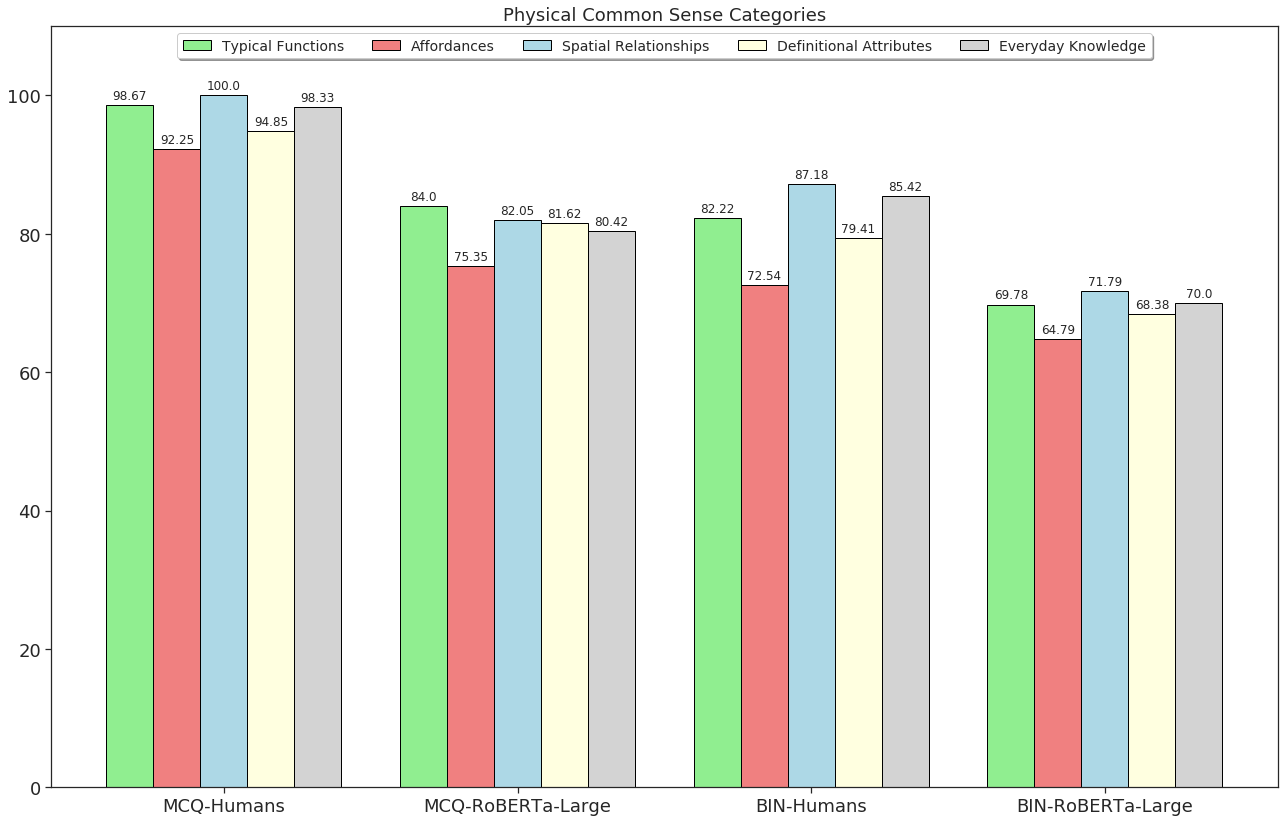

In [756]:
models_to_plot_and_str_mappings = {
    "MCQ-Humans": "MCQ-Humans",
    "large_roberta_bz4_accu2": "MCQ-RoBERTa-Large",
    "BIN-Humans": "BIN-Humans",
    "bz4_accu1_v2_contd": "BIN-RoBERTa-Large",
}
save_str = "imgs/grouped_bars_humans_models_cats.pdf"
fig = draw_column_charts_for_cond_perfs(qualt_dicts, mode="cat", start_block=1, end_block=20, 
                                        models_to_plot_and_str_mappings=models_to_plot_and_str_mappings, 
                                        bar_width=0.16, figsize=(22,14), save_str=save_str)

### Educational Levels

Version: 600 instances
--------------------------------------------------
Demographics: 5. education level
--------------------------------------------------
Most 10 year olds
MCQ-Humans: 98.4848%
large_roberta_bz4_accu2: 82.3232%
BIN-Humans: 89.8990%
bz4_accu1_v2_contd: 69.6970%
--------------------------------------------------
Not most 10 year olds
MCQ-Humans: 96.3636%
large_roberta_bz4_accu2: 81.4545%
BIN-Humans: 79.6364%
bz4_accu1_v2_contd: 65.0909%
--------------------------------------------------
Only domain experts
MCQ-Humans: 91.5663%
large_roberta_bz4_accu2: 79.5181%
BIN-Humans: 75.9036%
bz4_accu1_v2_contd: 69.8795%
--------------------------------------------------
Not sure
MCQ-Humans: 85.7143%
large_roberta_bz4_accu2: 71.4286%
BIN-Humans: 57.1429%
bz4_accu1_v2_contd: 53.5714%
--------------------------------------------------
['Most 10 year olds', 'Not most 10 year olds', 'Only domain experts', 'Not sure']


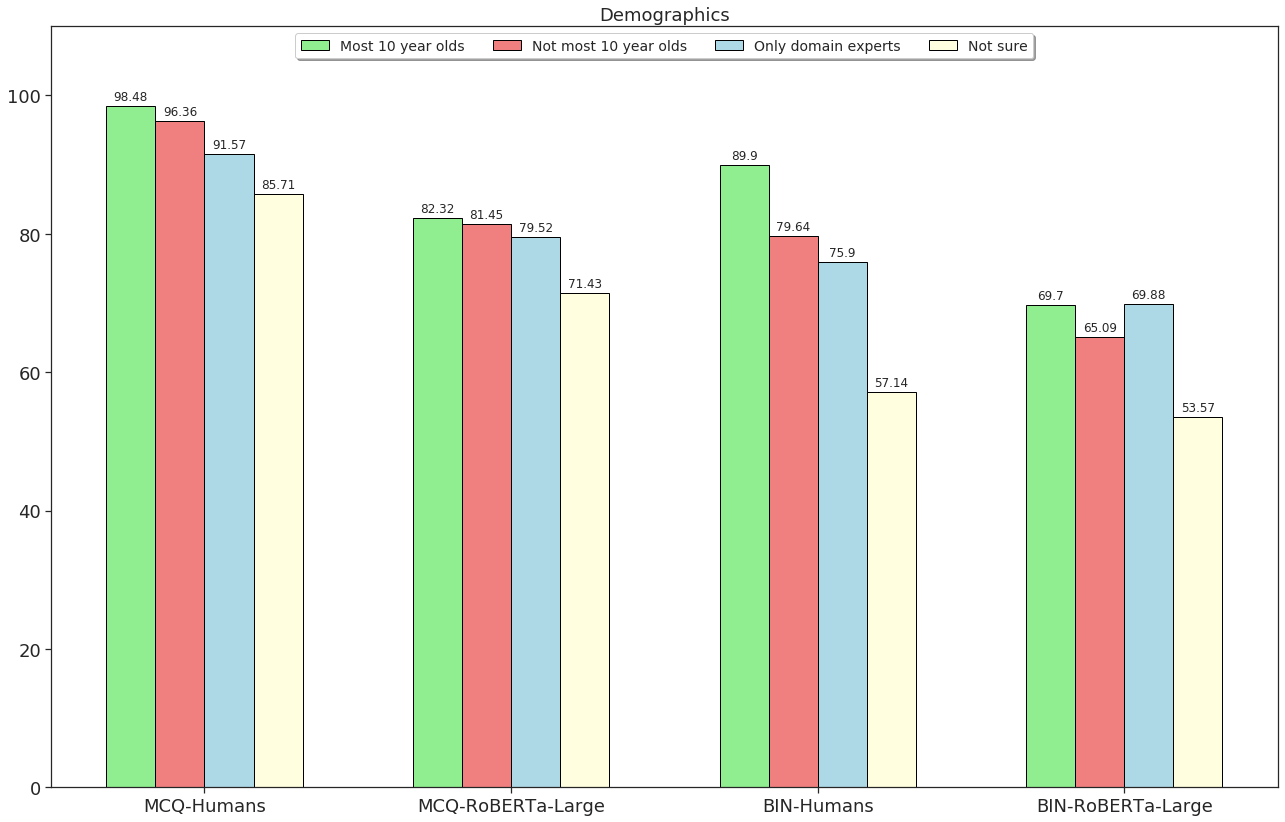

In [709]:
models_to_plot_and_str_mappings = {
    "MCQ-Humans": "MCQ-Humans",
    "large_roberta_bz4_accu2": "MCQ-RoBERTa-Large",
    "BIN-Humans": "BIN-Humans",
    "bz4_accu1_v2_contd": "BIN-RoBERTa-Large",
}
save_str = "imgs/grouped_bars_humans_models_edu.pdf"
fig = draw_column_charts_for_cond_perfs(qualt_dicts, mode="edu", start_block=1, end_block=20, 
                                        models_to_plot_and_str_mappings=models_to_plot_and_str_mappings, 
                                        bar_width=0.16, figsize=(22,14), save_str=save_str)

## Statistics

In [932]:
# functions
def overall_stats(qualt_dicts, mode="com", start_block=1, end_block=24, if_cs_kappa_mode="all"):
    assert mode in ["edu", "cat", "com", "clearness", "overall"]
    assert if_cs_kappa_mode in ["all", "no_ties"]
    
    mcq_qualt_dict, bin_qualt_dict = qualt_dicts
    qualt_ids = get_qualt_ids(start_block=start_block, end_block=end_block)
    
    # get number of annotators
    num_annotators_per_question = 0

    annots = mcq_qualt_dict[qualt_ids[0]]["annotations"]["1. choice"]
    num_annots = len(annots)
    num_annotators_per_question = max(num_annotators_per_question, num_annots)
    num_iaas = num_annotators_per_question * 2
    
    len_data = len(qualt_ids)
    
    mcq_choices = np.zeros((len_data, num_annotators_per_question))
    bin_choices = np.zeros((len_data, num_annotators_per_question))
    joint_choices = np.zeros((len_data, num_iaas))
    
    if if_cs_kappa_mode == "all":
        mcq_if_cs = np.zeros((len_data, num_annotators_per_question))
        bin_if_cs = np.zeros((len_data, num_annotators_per_question))
        joint_if_cs = np.zeros((len_data, num_iaas))
    else:
        mcq_if_cs = []
        bin_if_cs = []
        joint_if_cs = []
        
    mcq_mv_perf = []
    mcq_mv_if_cs = []
    bin_mv_perf = []
    bin_mv_if_cs = []
    joint_mv_if_cs = []
    
    mcq_cnt_if_cs = []
    bin_cnt_if_cs = []
    mcq_cnt_correct = []
    bin_cnt_correct = []
    
    for i in range(len(qualt_ids)):
        qualt_id = qualt_ids[i]
        
        mcq_annots = mcq_qualt_dict[qualt_id]["annotations"]
        bin_annots = bin_qualt_dict[qualt_id]["annotations"]
        mcq_gt = mcq_qualt_dict[qualt_id]["gt_label"]
        bin_gt = bin_qualt_dict[qualt_id]["gt_label"]
        
        mcq_human_choices = mcq_annots["1. choice"]
        bin_human_choices = bin_annots["1. choice"]
        mcq_human_choices_counter = Counter(mcq_human_choices)
        bin_human_choices_counter = Counter(bin_human_choices)
        mcq_human_choice, mcq_human_choice_cnt = mcq_human_choices_counter.most_common(1)[0]
        bin_human_choice, bin_human_choice_cnt = bin_human_choices_counter.most_common(1)[0]
        
        mcq_right = 0
        for ele in mcq_human_choices:
            if ele == mcq_gt:
                mcq_right += 1
        bin_right = 0
        for ele in bin_human_choices:
            if ele == bin_gt:
                bin_right += 1
        mcq_cnt_correct.append(mcq_right)
        bin_cnt_correct.append(bin_right)
        
        mcq_choices[i, :num_annotators_per_question] = mcq_human_choices
        bin_choices[i, :num_annotators_per_question] = bin_human_choices
        joint_choices[i, :num_annotators_per_question] = mcq_human_choices
        joint_choices[i, num_annotators_per_question:] = bin_human_choices
        
        assert mcq_human_choice_cnt > num_annotators_per_question // 2 and \
            bin_human_choice_cnt > num_annotators_per_question // 2
        
        mcq_human_if_css = mcq_annots["4. if common sense"]
        bin_human_if_css = bin_annots["4. if common sense"]
        joint_human_if_css = mcq_human_if_css + bin_human_if_css
        mcq_human_if_css_counter = Counter(mcq_human_if_css)
        bin_human_if_css_counter = Counter(bin_human_if_css)
        joint_human_if_css_counter = Counter(joint_human_if_css)
        mcq_human_if_cs, mcq_human_if_cs_cnt = mcq_human_if_css_counter.most_common(1)[0]
        bin_human_if_cs, bin_human_if_cs_cnt = bin_human_if_css_counter.most_common(1)[0]
        joint_human_if_cs, joint_human_if_cs_cnt = joint_human_if_css_counter.most_common(1)[0]
        
        mcq_cnt_if_cs.append(sum(mcq_human_if_css))
        bin_cnt_if_cs.append(sum(bin_human_if_css))
        
        if if_cs_kappa_mode == "all":
            mcq_if_cs[i, :num_annotators_per_question] = mcq_human_if_css
            bin_if_cs[i, :num_annotators_per_question] = bin_human_if_css
            joint_if_cs[i, :num_annotators_per_question] = mcq_human_if_css
            joint_if_cs[i, num_annotators_per_question:] = bin_human_if_css
        elif if_cs_kappa_mode == "no_ties":
            joint_humans_if_css_counter = Counter(mcq_human_if_css+bin_human_if_css)
            joint_humans_if_cs, joint_humans_if_cs_cnt = joint_humans_if_css_counter.most_common(1)[0]
            if joint_humans_if_cs_cnt == num_annotators_per_question:
                pass # don't include
            else:
                mcq_if_cs.append(mcq_human_if_css)
                bin_if_cs.append(bin_human_if_css)
                joint_if_cs.append(mcq_human_if_css+bin_human_if_css)
         
        assert mcq_human_if_cs_cnt > num_annotators_per_question // 2 and \
            bin_human_if_cs_cnt > num_annotators_per_question // 2
            
        if mcq_human_choice == mcq_gt:
            mcq_mv_perf.append(1)
        else:
            mcq_mv_perf.append(0)
        if bin_human_choice == bin_gt:
            bin_mv_perf.append(1)
        else:
            bin_mv_perf.append(0)

        mcq_mv_if_cs.append(mcq_human_if_cs)
        bin_mv_if_cs.append(bin_human_if_cs)
        if joint_human_if_cs_cnt > len(joint_human_if_css) // 2:
            if joint_human_if_cs == 1:
                joint_mv_if_cs.append(1)
            else:
                joint_mv_if_cs.append(-1)
        else:
            joint_mv_if_cs.append(0)
        
    mcq_mv_perf = np.asarray(mcq_mv_perf)
    bin_mv_perf = np.asarray(bin_mv_perf)
    mcq_mv_if_cs = np.asarray(mcq_mv_if_cs)
    bin_mv_if_cs = np.asarray(bin_mv_if_cs)
    joint_mv_if_cs = np.asarray(joint_mv_if_cs)
    
    mcq_mv_perf_acc = np.mean(mcq_mv_perf)
    bin_mv_perf_acc = np.mean(bin_mv_perf)
    mcq_mv_if_cs_acc = np.mean(mcq_mv_if_cs)
    bin_mv_if_cs_acc = np.mean(bin_mv_if_cs)
    # joint_mv_if_cs_acc = np.mean(joint_mv_if_cs)
    joint_mv_if_cs_acc = np.sum(joint_mv_if_cs==1) / len(joint_mv_if_cs)
    joint_mv_if_not_cs_acc = np.sum(joint_mv_if_cs==-1) / len(joint_mv_if_cs)
    joint_mv_if_neutral_acc = np.sum(joint_mv_if_cs==0) / len(joint_mv_if_cs)
    
    print ("MCQ-MV-Performance: {:.2f}%".format(mcq_mv_perf_acc*100))
    print ("BIN-MV-Performance: {:.2f}%".format(bin_mv_perf_acc*100))
    print ("MCQ-MV-If-CS:  {:.2f}%".format(mcq_mv_if_cs_acc*100))
    print ("BIN-MV-If-CS:  {:.2f}%".format(bin_mv_if_cs_acc*100))
    print ("JON-MV-If-CS:  {:.2f}%".format(joint_mv_if_cs_acc*100))
    print ("JON-MV-If-NCS: {:.2f}%".format(joint_mv_if_not_cs_acc*100))
    print ("JON-MV-If-NT:  {:.2f}%".format(joint_mv_if_neutral_acc*100))
    
    print ('-'*50)
    mcq_cnt_correct_cnt = Counter(mcq_cnt_correct)
    bin_cnt_correct_cnt = Counter(bin_cnt_correct)
    mcq_cnt_if_cs_cnt = Counter(mcq_cnt_if_cs)
    bin_cnt_if_cs_cnt = Counter(bin_cnt_if_cs)
    all_res_str = ["MCQ Correct", "MCQ If CS", "BIN Correct", "BIN IF CS"]
    all_res_l = [mcq_cnt_correct_cnt, mcq_cnt_if_cs_cnt, bin_cnt_correct_cnt, bin_cnt_if_cs_cnt]
    for i in range(len(all_res_l)):
        str_ = all_res_str[i]
        cnt_d = all_res_l[i]
        print (str_)
        for ele in sorted(cnt_d):
            print ("{}: {}/{}={:.1f}%".format(ele, cnt_d[ele], len(mcq_cnt_correct), float(cnt_d[ele])/len(mcq_cnt_correct)*100))
        print ('.'*50)
        
    # Kappas and Fleiss
    len_data = len(mcq_choices)
    mcq_choices = np.transpose(mcq_choices).astype(np.int32)
    bin_choices = np.transpose(bin_choices).astype(np.int32)
    joint_choices = np.transpose(joint_choices).astype(np.int32)
    
    taskdata_mcq_choices = []
    taskdata_bin_choices = []
    taskdata_joint_choices = []
    for i in range(num_annotators_per_question):
        mcq_tmp = [[i, str(j), str(mcq_choices[i][j])] for j in range(len_data)]
        bin_tmp = [[i, str(j), str(bin_choices[i][j])] for j in range(len_data)]
        taskdata_mcq_choices += mcq_tmp
        taskdata_bin_choices += bin_tmp
    for i in range(num_iaas):
        joint_tmp = [[i, str(j), str(joint_choices[i][j])] for j in range(len_data)]
        taskdata_joint_choices += joint_tmp
        
    rating_mcq_choices = agreement.AnnotationTask(data=taskdata_mcq_choices)
    rating_bin_choices = agreement.AnnotationTask(data=taskdata_bin_choices)
    rating_joint_choices = agreement.AnnotationTask(data=taskdata_joint_choices)
    
    print ('-'*50)
    print ("Choices:")
    print ("MCQ Kappa:    {:.2f}".format(rating_mcq_choices.kappa()))
    print ("BIN Kappa:    {:.2f}".format(rating_bin_choices.kappa()))
    print ("Joint Kappa:  {:.2f}".format(rating_joint_choices.kappa()))
    print ("MCQ Fleiss:   {:.2f}".format(rating_mcq_choices.multi_kappa()))
    print ("BIN Fleiss:   {:.2f}".format(rating_bin_choices.multi_kappa()))
    print ("Joint Fleiss: {:.2f}".format(rating_joint_choices.multi_kappa()))
    
    if if_cs_kappa_mode == "no_ties":
        mcq_if_cs = np.asarray(mcq_if_cs)
        bin_if_cs = np.asarray(bin_if_cs)
        joint_if_cs = np.asarray(joint_if_cs)
    
    len_data = len(mcq_if_cs)
    mcq_if_cs = np.transpose(mcq_if_cs).astype(np.int32)
    bin_if_cs = np.transpose(bin_if_cs).astype(np.int32)
    joint_if_cs = np.transpose(joint_if_cs).astype(np.int32)
    
    taskdata_mcq_if_cs = []
    taskdata_bin_if_cs = []
    taskdata_joint_if_cs = []
    for i in range(num_annotators_per_question):
        mcq_tmp = [[i, str(j), str(mcq_if_cs[i][j])] for j in range(len_data)]
        bin_tmp = [[i, str(j), str(bin_if_cs[i][j])] for j in range(len_data)]
        taskdata_mcq_if_cs += mcq_tmp
        taskdata_bin_if_cs += bin_tmp
    for i in range(num_iaas):
        joint_tmp = [[i, str(j), str(joint_if_cs[i][j])] for j in range(len_data)]
        taskdata_joint_if_cs += joint_tmp
        
    rating_mcq_if_cs = agreement.AnnotationTask(data=taskdata_mcq_if_cs)
    rating_bin_if_cs = agreement.AnnotationTask(data=taskdata_bin_if_cs)
    rating_joint_if_cs = agreement.AnnotationTask(data=taskdata_joint_if_cs)
    
    print ('-'*50)
    print ("If CS (mode = {}):".format(if_cs_kappa_mode))
    print ("MCQ Kappa:    {:.2f}".format(rating_mcq_if_cs.kappa()))
    print ("BIN Kappa:    {:.2f}".format(rating_bin_if_cs.kappa()))
    print ("Joint Kappa:  {:.2f}".format(rating_joint_if_cs.kappa()))
    print ("MCQ Fleiss:   {:.2f}".format(rating_mcq_if_cs.multi_kappa()))
    print ("BIN Fleiss:   {:.2f}".format(rating_bin_if_cs.multi_kappa()))
    print ("Joint Fleiss: {:.2f}".format(rating_joint_if_cs.multi_kappa()))
    print ('-'*50)
    
    return None

In [934]:
overall_stats(qualt_dicts, mode="cat", start_block=1, end_block=20, if_cs_kappa_mode="all")

--------------------------------------------------
Version: 600 instances
MCQ-MV-Performance: 95.00%
BIN-MV-Performance: 80.00%
MCQ-MV-If-CS:  73.00%
BIN-MV-If-CS:  70.50%
JON-MV-If-CS:  66.67%
JON-MV-If-NCS: 21.33%
JON-MV-If-NT:  12.00%
--------------------------------------------------
MCQ Correct
0: 5/600=0.8%
1: 25/600=4.2%
2: 77/600=12.8%
3: 493/600=82.2%
..................................................
MCQ If CS
0: 40/600=6.7%
1: 122/600=20.3%
2: 157/600=26.2%
3: 281/600=46.8%
..................................................
BIN Correct
0: 38/600=6.3%
1: 82/600=13.7%
2: 168/600=28.0%
3: 312/600=52.0%
..................................................
BIN IF CS
0: 71/600=11.8%
1: 106/600=17.7%
2: 156/600=26.0%
3: 267/600=44.5%
..................................................
--------------------------------------------------
Choices:
MCQ Kappa:    0.77
BIN Kappa:    0.43
Joint Kappa:  0.25
MCQ Fleiss:   0.77
BIN Fleiss:   0.43
Joint Fleiss: 0.25
-----------------------------

In [548]:
overall_stats(qualt_dicts, mode="cat", start_block=1, end_block=24, if_cs_kappa_mode="no_ties")

Version: 720 instances
--------------------------------------------------
MCQ-MV-Performance: 93.75%
BIN-MV-Performance: 77.22%
MCQ-MV-If-CS: 72.22%
BIN-MV-If-CS: 69.03%
--------------------------------------------------
Choices:
MCQ Kappa:    0.7456801512839593
BIN Kappa:    0.41180413803238264
Joint Kappa:  0.24083019495870367
MCQ Fleiss:   0.7456709398624188
BIN Fleiss:   0.41179243059810533
Joint Fleiss: 0.23906624553750563
--------------------------------------------------
If CS (mode = no_ties):
MCQ Kappa:    0.2864650898597096
BIN Kappa:    0.4077023146142955
Joint Kappa:  0.3444619124280066
MCQ Fleiss:   0.2870645079257437
BIN Fleiss:   0.40787626357169604
Joint Fleiss: 0.3460847277511229
--------------------------------------------------


In [549]:
overall_stats(qualt_dicts, mode="cat", start_block=1, end_block=20, if_cs_kappa_mode="all")

Version: 600 instances
--------------------------------------------------
MCQ-MV-Performance: 95.00%
BIN-MV-Performance: 80.00%
MCQ-MV-If-CS: 73.00%
BIN-MV-If-CS: 70.50%
--------------------------------------------------
Choices:
MCQ Kappa:    0.7729111151280437
BIN Kappa:    0.43283968166754
Joint Kappa:  0.2543260726883649
MCQ Fleiss:   0.7729035322406481
BIN Fleiss:   0.4327549955376726
Joint Fleiss: 0.2524486642133701
--------------------------------------------------
If CS (mode = all):
MCQ Kappa:    0.24744482238902385
BIN Kappa:    0.3342267099114477
Joint Kappa:  0.2810728866865493
MCQ Fleiss:   0.248032486434039
BIN Fleiss:   0.3348959611430314
Joint Fleiss: 0.28244730935161555
--------------------------------------------------


In [550]:
overall_stats(qualt_dicts, mode="cat", start_block=1, end_block=20, if_cs_kappa_mode="no_ties")

Version: 600 instances
--------------------------------------------------
MCQ-MV-Performance: 95.00%
BIN-MV-Performance: 80.00%
MCQ-MV-If-CS: 73.00%
BIN-MV-If-CS: 70.50%
--------------------------------------------------
Choices:
MCQ Kappa:    0.7729111151280437
BIN Kappa:    0.43283968166754
Joint Kappa:  0.2543260726883649
MCQ Fleiss:   0.7729035322406481
BIN Fleiss:   0.4327549955376726
Joint Fleiss: 0.2524486642133701
--------------------------------------------------
If CS (mode = no_ties):
MCQ Kappa:    0.2929813091407725
BIN Kappa:    0.40033022786399863
Joint Kappa:  0.34166818554332207
MCQ Fleiss:   0.29375046444229747
BIN Fleiss:   0.40059557086951053
Joint Fleiss: 0.343084964436553
--------------------------------------------------


### Other Stats

## New BIN Performances

In [881]:
# functions
def new_bins_perf(qualt_dicts, mode="com", start_block=1, end_block=24, 
                  if_cs_kappa_mode="all", show_examples_cnt=None):
    
    assert mode in ["edu", "cat", "com", "clearness", "overall"]
    assert if_cs_kappa_mode in ["all", "no_ties"]
    
    mcq_qualt_dict, bin_qualt_dict = qualt_dicts
    qualt_ids = get_qualt_ids(start_block=start_block, end_block=end_block)
    
    # get number of annotators
    num_annotators_per_question = 0

    annots = mcq_qualt_dict[qualt_ids[0]]["annotations"]["1. choice"]
    num_annots = len(annots)
    num_annotators_per_question = max(num_annotators_per_question, num_annots)
    num_iaas = num_annotators_per_question * 2
    
    len_data = len(qualt_ids)
        
    mcq_mv_perf = []
    mcq_mv_if_cs = []
    bin_mv_perf = []
    bin_mv_perf_compl = []
    bin_mv_if_cs = []
    
    if show_examples_cnt is None:
        show_examples_cnt = -1
    else:
        show_examples_cnt = max(0, show_examples_cnt)
        show_examples_cnt = min(len(qualt_ids), show_examples_cnt)
        show_cnt = 0

    for i in range(len(qualt_ids)):
        qualt_id = qualt_ids[i]
        
        mcq_annots = mcq_qualt_dict[qualt_id]["annotations"]
        bin_annots = bin_qualt_dict[qualt_id]["annotations"]
        mcq_gt = mcq_qualt_dict[qualt_id]["gt_label"]
        bin_gt = bin_qualt_dict[qualt_id]["gt_label"]
        if 'gt_label_compl' in bin_qualt_dict[qualt_id]:
            bin_gt_compl = bin_qualt_dict[qualt_id]["gt_label_compl"]
            assert bin_gt_compl == 1 - bin_gt
        
        mcq_human_choices = mcq_annots["1. choice"]
        bin_human_choices = bin_annots["1. choice"]
            
        mcq_human_choices_counter = Counter(mcq_human_choices)
        bin_human_choices_counter = Counter(bin_human_choices)
        mcq_human_choice, mcq_human_choice_cnt = mcq_human_choices_counter.most_common(1)[0]
        bin_human_choice, bin_human_choice_cnt = bin_human_choices_counter.most_common(1)[0]
        
        if "1. choice compl" in bin_annots:
            bin_human_choices_compl = bin_annots["1. choice compl"]
            bin_human_choices_compl_counter = Counter(bin_human_choices_compl)
            bin_human_choice_compl, bin_human_choice_compl_cnt = bin_human_choices_compl_counter.most_common(1)[0]
        
        assert mcq_human_choice_cnt > num_annotators_per_question // 2 and \
            bin_human_choice_cnt > num_annotators_per_question // 2
        
        mcq_human_if_css = mcq_annots["4. if common sense"]
        bin_human_if_css = bin_annots["4. if common sense"]
        joint_human_if_css = mcq_human_if_css + bin_human_if_css
        mcq_human_if_css_counter = Counter(mcq_human_if_css)
        bin_human_if_css_counter = Counter(bin_human_if_css)
        joint_human_if_css_counter = Counter(joint_human_if_css)
        mcq_human_if_cs, mcq_human_if_cs_cnt = mcq_human_if_css_counter.most_common(1)[0]
        bin_human_if_cs, bin_human_if_cs_cnt = bin_human_if_css_counter.most_common(1)[0]
        joint_human_if_cs, joint_human_if_cs_cnt = joint_human_if_css_counter.most_common(1)[0]
         
        assert mcq_human_if_cs_cnt > num_annotators_per_question // 2 and \
            bin_human_if_cs_cnt > num_annotators_per_question // 2
            
        if mcq_human_choice == mcq_gt:
            mcq_mv_perf.append(1)
        else:
            mcq_mv_perf.append(0)
        
        if bin_human_choice == bin_gt:
            bin_mv_perf.append(1)
        else:
            bin_mv_perf.append(0)
            
        if "1. choice compl" in bin_annots:
            if bin_human_choice == bin_gt and bin_human_choice_compl == bin_gt_compl:
                bin_mv_perf_compl.append(1)
            else:
                bin_mv_perf_compl.append(0)

        mcq_mv_if_cs.append(mcq_human_if_cs)
        bin_mv_if_cs.append(bin_human_if_cs)
        
        if show_cnt < show_examples_cnt:
            curr_mcq_goal = mcq_qualt_dict[qualt_id]["goal"]
            curr_mcq_sol1 = mcq_qualt_dict[qualt_id]["sol1"]
            curr_mcq_sol2 = mcq_qualt_dict[qualt_id]["sol2"]
            curr_bin_sol  = bin_qualt_dict[qualt_id]["sol"]
            curr_bin_sol_id = "sol1" if curr_mcq_sol1 == curr_bin_sol else "sol2"
            if joint_human_if_cs_cnt == len(joint_human_if_css):
                joint_cs_str = "Neutral"
            else:
                if joint_human_if_cs == 1:
                    joint_cs_str = "Common Sense"
                else:
                    joint_cs_str = "Non-Common Sense"
            if mcq_human_choice == mcq_gt and bin_human_choice != bin_gt:
                print ("Goal:     {}".format(curr_mcq_goal))
                print ("Sol1:     {}".format(curr_mcq_sol1))
                print ("Sol2:     {}".format(curr_mcq_sol2))
                print ("MCQ GT:   {}".format(mcq_gt))
                print ("BIN sol:  {}".format(curr_bin_sol_id))
                print ("BIN GT:   {}".format(bin_gt))
                print ("Joint CS: {}".format(joint_cs_str))
                print ('-'*50)
                show_cnt += 1
        
    mcq_mv_perf = np.asarray(mcq_mv_perf)
    bin_mv_perf = np.asarray(bin_mv_perf)
    mcq_mv_if_cs = np.asarray(mcq_mv_if_cs)
    bin_mv_if_cs = np.asarray(bin_mv_if_cs)
    bin_mv_perf_compl = np.asarray(bin_mv_perf_compl)
    
    mcq_mv_perf_acc = np.mean(mcq_mv_perf)
    bin_mv_perf_acc = np.mean(bin_mv_perf)
    mcq_mv_if_cs_acc = np.mean(mcq_mv_if_cs)
    bin_mv_if_cs_acc = np.mean(bin_mv_if_cs)
    bin_mv_perf_compl_acc = np.mean(bin_mv_perf_compl)
    
    print ("MCQ-MV-Performance:            {:.2f}%".format(mcq_mv_perf_acc*100))
    print ("BIN-MV-Performance:            {:.2f}%".format(bin_mv_perf_acc*100))
    print ("BIN-MV-Performance (w. Compl): {:.2f}%".format(bin_mv_perf_compl_acc*100))
    print ("MCQ-MV-If-CS: {:.2f}%".format(mcq_mv_if_cs_acc*100))
    print ("BIN-MV-If-CS: {:.2f}%".format(bin_mv_if_cs_acc*100))
    
    return None

In [726]:
new_bins_perf(qualt_dicts, mode="cat", start_block=1, end_block=24, if_cs_kappa_mode="all")

Version: 720 instances
--------------------------------------------------
MCQ-MV-Performance:            93.75%
BIN-MV-Performance:            77.22%
BIN-MV-Performance (w. Compl): 71.56%
MCQ-MV-If-CS: 72.22%
BIN-MV-If-CS: 69.03%


In [727]:
new_bins_perf(qualt_dicts, mode="cat", start_block=1, end_block=20, if_cs_kappa_mode="all")

Version: 600 instances
--------------------------------------------------
MCQ-MV-Performance:            95.00%
BIN-MV-Performance:            80.00%
BIN-MV-Performance (w. Compl): 71.56%
MCQ-MV-If-CS: 73.00%
BIN-MV-If-CS: 70.50%


## Qualitative Examples

### BIN-Humans

In [908]:
new_bins_perf(qualt_dicts, mode="cat", start_block=1, end_block=24, if_cs_kappa_mode="all", show_examples_cnt=1)

--------------------------------------------------
Version: 720 instances
Goal:     How to get water out of coconut.
Sol1:     Use a hammer and a nail to pierce a few holes in the top of the coconut. Pour into cup.
Sol2:     Use a hammer and a nail to pierce a few holes in the top of the coconut. Pour into colander.
MCQ GT:   0
BIN sol:  sol2
BIN GT:   0
Joint CS: Common Sense
--------------------------------------------------
MCQ-MV-Performance:            93.75%
BIN-MV-Performance:            77.22%
BIN-MV-Performance (w. Compl): 71.56%
MCQ-MV-If-CS: 72.22%
BIN-MV-If-CS: 69.03%


# END